# 2.5 Data Analysis: Communities

In this notebook we  explore the characteristics of web trackers by analyzing the graph community metrics of the web crawled data. Specifically, we will be looking at the tracker distribution within the communities computed by: 

- (Strong) Graph Components
- Modularity
- Statistical Inference 

### Dataset Configuration

In [1]:
data_name = 'chrome-run-01'

### Set Up

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
import sys
# Append own directories to sys.path
references_path = os.path.join( '..', 'references')
visualization_path = os.path.join('..', 'src', 'visualization')
# Append paths to sys.path
sys.path.append(references_path)
sys.path.append(visualization_path)
# Import own modules
import dictionary
import visualize

For this analysis, we import the labeled ```interim``` data from the csv file:

In [5]:
formatted_data_name = formatted_string = f"{data_name.split('-')[0].capitalize()} (Run {data_name.split('-')[2].zfill(2)})"

# Import and label the csv data
csv_file_path = os.path.join('..', 'data', 'interim', f"labeled-{data_name}.csv")
df = pd.read_csv(csv_file_path, index_col=False)

print(df.shape)
# print(df.columns)

# Set color palette for labels
palette={0: 'tab:blue', 1: 'tab:red'}

(25338, 64)


### Overview

First we calculate the inital label distribution:

In [6]:
# Calculate the count of each label in the 'Label' column
label_counts = df['Label'].value_counts()

# Calculate the percentage of each label
label_percentages = label_counts / df['Label'].count() * 100

initial_percentage_0 = label_percentages.get(0)
initial_percentage_1 = label_percentages.get(1) 

print("Initial Percentage of Label 0:", initial_percentage_0)
print("Initial Percentage of Label 1:", initial_percentage_1)

Initial Percentage of Label 0: 67.18367669113584
Initial Percentage of Label 1: 32.816323308864156


Now we analyze the distinct classes that are created by the mentioned approaches. We will specifically look at how many of these classes are more balanced than our inital distribution:

In [7]:
import pandas as pd

# Function to group data and prepare for plotting
def prepare_data_for_plotting(group_column):
    grouped_data = df.groupby(group_column)['Label'].value_counts().unstack(fill_value=0)
    grouped_data['total'] = grouped_data.sum(axis=1)
    grouped_data['balance'] = grouped_data.apply(lambda row: min(row[0], row[1]) / row['total'], axis=1)
    grouped_data['percentage_0'] = grouped_data[0] / grouped_data['total'] * 100
    return grouped_data

# Prepare data for each classification
classifications = ['modularity_class', 'componentnumber', 'stat_inf_class', 'strongcompnum']
all_data = {cls: prepare_data_for_plotting(cls) for cls in classifications}

# Calculate summary statistics for each classification
summary_stats = {}
total_nodes = df.shape[0]
for cls, data in all_data.items():
    more_balanced = data[(data['percentage_0'] > initial_percentage_1) & (data['percentage_0'] < initial_percentage_0)]
    summary_stats[cls] = {
        'Total Classes': data.shape[0],
        'Median Size': data['total'].median(),
        'Mean Size': round(data['total'].mean(), 2),
        'Standard Deviation of Node Sizes': round(data['total'].std(), 2), 
        'Balanced Classes': more_balanced.shape[0],
        'Median Size of Balanced Classes': more_balanced['total'].median(),
        'Mean Size of Balanced Classes': round(more_balanced['total'].mean(), 2),
        'Nodes in Balanced Classes (%)': round(more_balanced['total'].sum() / total_nodes * 100, 2)
    }

# Create a DataFrame from the summary statistics
summary_df = pd.DataFrame(summary_stats).T
summary_df.columns = [
    'Total Classes', 'Median Size', 'Mean Size', 'Standard Deviation of Node Sizes', 'Balanced Classes', 'Median Size of Balanced Classes',
    'Mean Size of Balanced Classes', 'Nodes in Balanced Classes (%)',
     
]
summary_df


,Total Classes,Median Size,Mean Size,Standard Deviation of Node Sizes,Balanced Classes,Median Size of Balanced Classes,Mean Size of Balanced Classes,Nodes in Balanced Classes (%)
modularity_class,159.0,3.0,159.36,650.46,25.0,3.0,439.24,43.34
componentnumber,113.0,2.0,224.23,2348.67,17.0,3.0,1471.41,98.72
stat_inf_class,475.0,40.0,53.34,82.23,201.0,55.0,61.14,48.50
strongcompnum,25263.0,1.0,1.00,0.16,9.0,2.0,2.11,0.07


### Visualization

We visualize these results by representing each community as a point in a scatter plot and we look at its node size and label distribution:

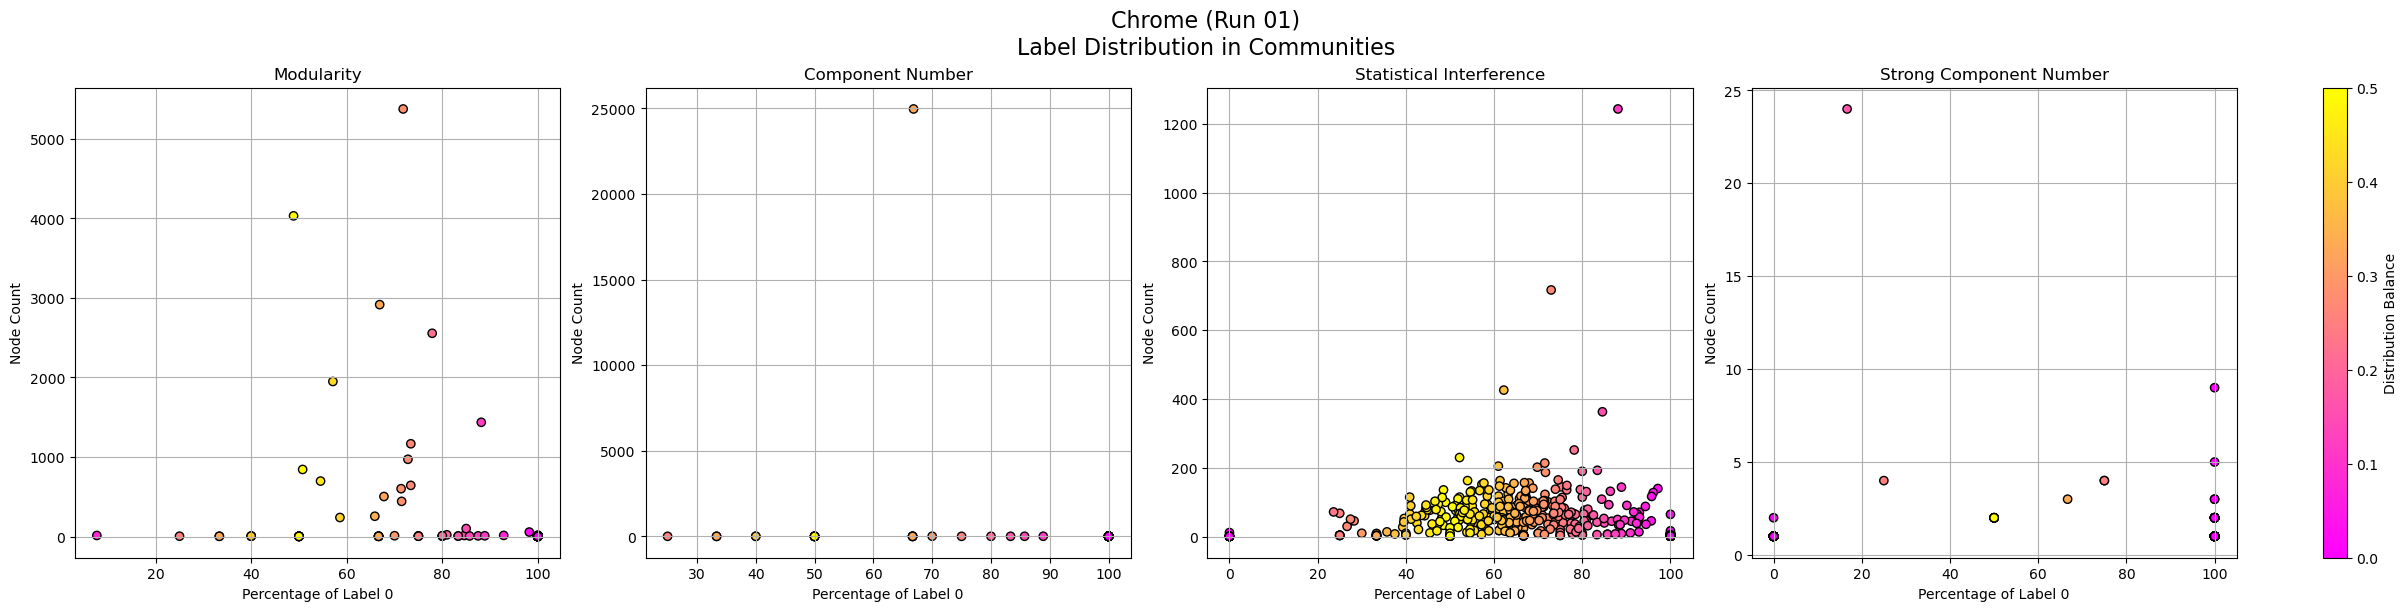

In [8]:
# Create figure and axes for the scatter plots
fig, axs = plt.subplots(1, 4, figsize=(24, 6), constrained_layout=True)

# Function to create scatter plots on the provided axes
def create_scatter_plot(data, title, ax):
    scatter = ax.scatter(data['percentage_0'], data['total'], c=data['balance'], cmap='spring', edgecolor='black')
    ax.set_xlabel('Percentage of Label 0')
    ax.set_ylabel('Node Count')
    ax.grid(True)
    return scatter

# Generate scatter plots for each classification
for ax, (cls, data) in zip(axs, all_data.items()):
    scatter = create_scatter_plot(data, f'{cls} Distribution', ax)
    ax.set_title(dictionary.community_metrics[cls])
fig.colorbar(scatter, ax=axs, orientation='vertical', fraction=0.05, pad=0.04, label='Distribution Balance')

fig.suptitle(f'{formatted_data_name}\nLabel Distribution in Communities', fontsize=16)
plt.show()

visualize.save_report_figure(fig, data_name, 'communities')

### Graph Components

We want to specifically analyze the graph components now:

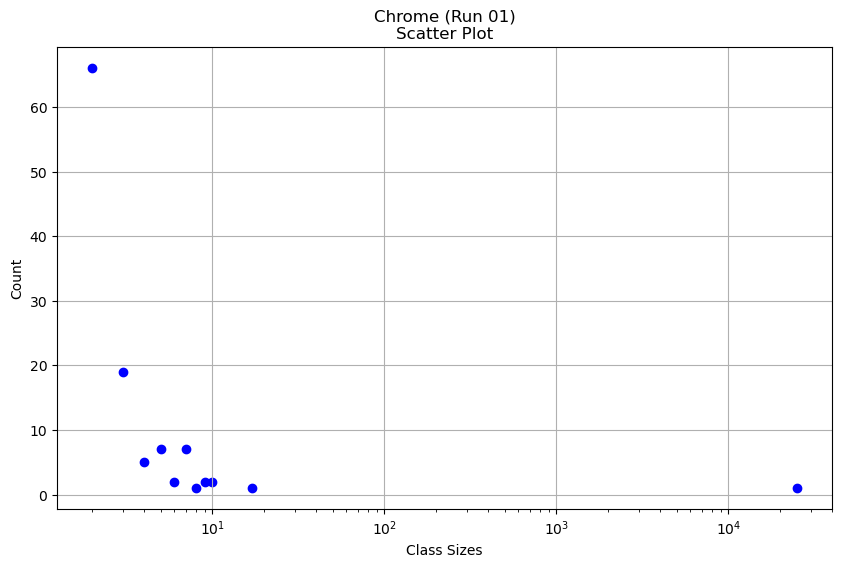

In [9]:
# Calculate the size of each class
class_sizes = df['componentnumber'].value_counts()

# Calculate the size of each class
class_sizes = df['componentnumber'].value_counts()

# Count how many classes have the same size
size_counts = class_sizes.value_counts()

# Preparing data for scatter plot
sizes = size_counts.index
counts = size_counts.values

# Creating scatter plot
fig = plt.figure(figsize=(10, 6))
plt.scatter(sizes, counts, color='blue')
plt.title(f'{formatted_data_name}\nScatter Plot')
plt.xlabel('Class Sizes')
plt.ylabel('Count')
plt.xscale('log')
plt.grid(True)
plt.show()

# Create DataFrame for the table
table_data = pd.DataFrame({
    'Class Size': sizes,
    'Count of Classes': counts
})

# Sort the table by class size for better readability
table_data = table_data.sort_values(by='Class Size')

# Display the table
table_data

visualize.save_report_figure(fig, data_name, 'graph_components')

We take a closer look at the biggest graph components:

In [10]:
total_size = len(df)
total_ones = df['Label'].sum()
total_zeros = total_size - total_ones

# Group by 'componentnumber' and calculate necessary statistics
grouped = df.groupby('componentnumber')
class_summary = grouped['Label'].agg(
    class_size='count',
    ones_count=lambda x: x.sum(),
    zeros_count=lambda x: x.size - x.sum()
)

# Sort by class size in descending order and select top 5
class_summary = class_summary.sort_values(by='class_size', ascending=False).head(5)

# Calculating percentages and rounding to 2 decimal places
class_summary['class_size_percent'] = (class_summary['class_size'] / total_size * 100).round(2)
class_summary['ones_percent_total'] = (class_summary['ones_count'] / total_ones * 100).round(2)
class_summary['zeros_percent_total'] = (class_summary['zeros_count'] / total_zeros * 100).round(2)

# Calculate Trackers (%) based on size of nodes
class_summary['Trackers (%)'] = (class_summary['ones_count'] / class_summary['class_size'] * 100).round(2)

# Resetting the index if needed to clean up the table's appearance
class_summary.reset_index(inplace=True)

class_summary.rename(columns={
    'componentnumber': 'Component Number',
    'class_size': 'Size (Nodes)',
    'ones_count': 'Trackers',
    'zeros_count': 'Non-Trackers',
    'class_size_percent': 'Share Of All Nodes (%)',
    'ones_percent_total': 'Share Of All Trackers (%)',
    'zeros_percent_total': 'Share Of All Non-Trackers (%)'
}, inplace=True)

class_summary[['Component Number', 'Size (Nodes)', 'Trackers', 'Trackers (%)', 'Non-Trackers', 'Share Of All Trackers (%)', 'Share Of All Non-Trackers (%)', 'Share Of All Nodes (%)']]



,Component Number,Size (Nodes),Trackers,Trackers (%),Non-Trackers,Share Of All Trackers (%),Share Of All Non-Trackers (%),Share Of All Nodes (%)
0,0,24970,8282,33.17,16688,99.60,98.03,98.55
1,91,17,0,0.00,17,0.00,0.10,0.07
2,31,10,0,0.00,10,0.00,0.06,0.04
3,23,10,3,30.00,7,0.04,0.04,0.04
4,50,9,1,11.11,8,0.01,0.05,0.04
